# ネ申エクセルについて
Excelで印刷物での見栄えを優先させて作成された表がしばしば見受けられます。
これらのExcelワークブックは、ネ申エクセル(神エクセル）と呼ばれたりします。
神エクセルは印刷物を作成すること（だけ）を念頭に置かれて作成されるため、
そこに含まれたデータを再利用する際に、余分な手間が必要となり、データの効率的な利用の障害となっています。

科研費申請書で有名になった方眼紙エクセルは極端な例ですが、
セルの結合を多用しているため、標準的な手法ではその中のデータを簡単にはプログラムに取り込めない
ということはしばしばあります。

一例として、首相官邸ホームページに掲載されている都道府県別のコロナワクチン接種状況のデータを見て見ましょう。

- 都道府県別の実績　https://www.kantei.go.jp/jp/content/kenbetsu-vaccination_data2.xlsx

この表には、都道府県別に、一般接種および医療対象者の二つの接種対象毎に表が作成されています。
また、ワクチンの種別毎に1回目としての接種回数と2回目としての接種回数がデータにふくまれています。
一般接種と医療対象者等のデータはそれぞれ別ワークシートに収められており、
テーブルの形式もそれぞれで若干の違いがあります。　
それらのテーブルでは、各列の項目名の行はセルの結合を組み合わせて作られており、
データを取り出す為には、worksheet毎にデータの処理を行う必要があります。

In [1]:
import pandas
from urllib.request import urlopen
import openpyxl
from io import StringIO,BytesIO
wb=openpyxl.load_workbook(
        BytesIO(
            urlopen("https://www.kantei.go.jp/jp/content/kenbetsu-vaccination_data2.xlsx").read()
        ))
df0=pandas.read_excel(
    urlopen("https://www.kantei.go.jp/jp/content/kenbetsu-vaccination_data2.xlsx").read(),
    header=2,sheet_name=0)

In [2]:
df0.columns, df0["都道府県名"]

(Index(['都道府県名', '接種回数', '内１回目', '内２回目', 'Unnamed: 4'], dtype='object'),
 0                                                    合計
 1                                                01 北海道
 2                                                02 青森県
 3                                                03 岩手県
 4                                                04 宮城県
 5                                                05 秋田県
 6                                                06 山形県
 7                                                07 福島県
 8                                                08 茨城県
 9                                                09 栃木県
 10                                               10 群馬県
 11                                               11 埼玉県
 12                                               12 千葉県
 13                                               13 東京都
 14                                              14 神奈川県
 15                                               15 新潟県
 16            

このように、データ以外の情報　（ここでは"注”）もテーブル中にあり、プログラムでのデータ処理の例外扱いを増やしています。（注などは、テキストボックスや、フッターにいれることを検討して欲しいところです。ただ、フッターに入れることのできる文の長さには制限がある。~~テキストボックスはテーブルの長さが変わったときに位置が追随しないという問題はあります。~~ テキストボックスはプロパティの”セルに合わせて移動”を選択することで、セルの追加などに合わせてテキストボックスの位置が調整されます。）

Excelの「データの分析機能」でも注などをテーブルの中に埋め込んだ場合、これらも対象のデータとして取り込もうとしているようです。

openpyxlを用いて、ワークシートを読み込んだ場合、プログラム側でテーブルの構造を意識して、
明示的にセル位置を指定する必要があります。

In [262]:
print(wb.worksheets, end="\n\n")
for i in range(1,5):
    [print(c.value, end=", ") for c in wb.worksheets[0][f"{i}"]]
    print()

[<Worksheet "総接種回数">, <Worksheet "一般接種">, <Worksheet "医療従事者等">]

これまでのワクチン総接種回数（都道府県別）, None, None, None, None, 
None, None, None, （8月23日公表時点）, None, 
都道府県名, 接種回数, 内１回目, 内２回目, None, 
合計, 112171725, 62773195, 49398530, None, 


余分なデータがあることで、どんな影響がでるか、データをグラフ化して見て見ましょう。

<AxesSubplot:xlabel='都道府県名'>

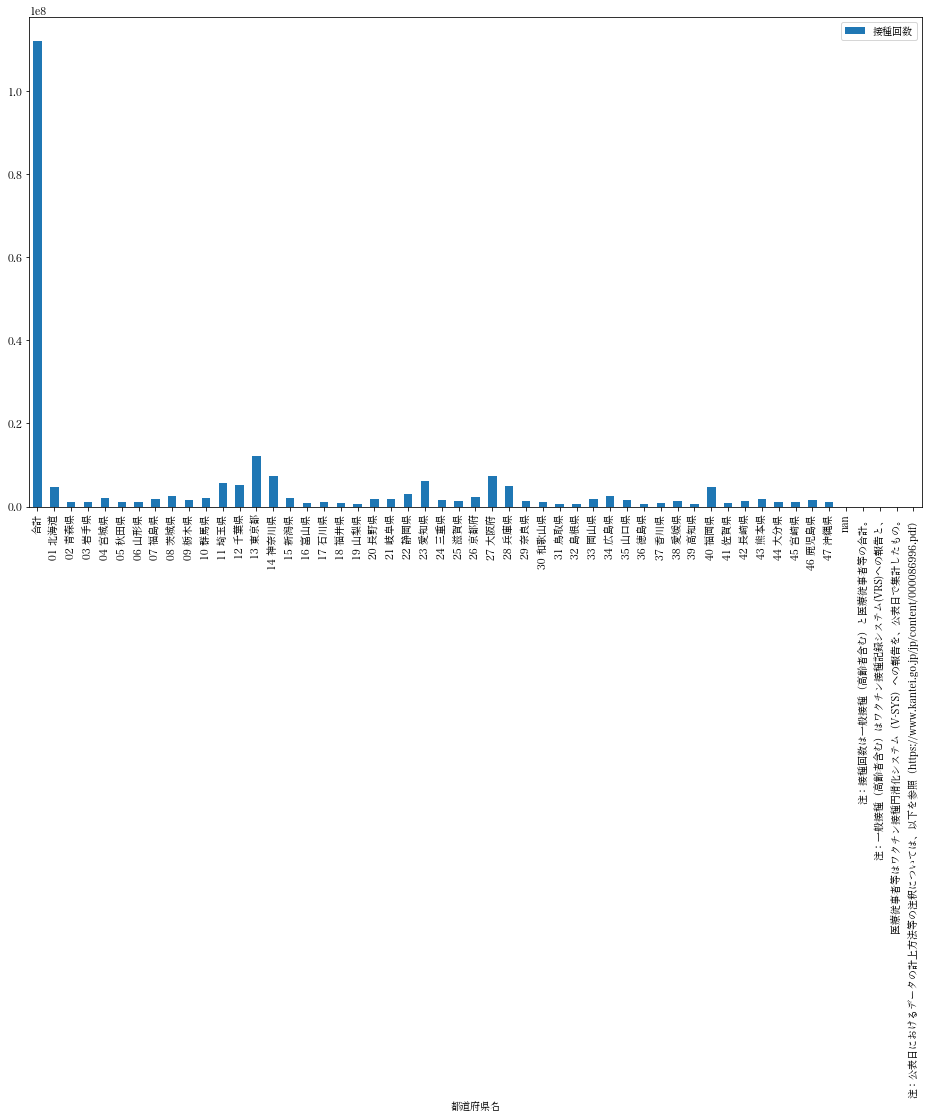

In [24]:
import matplotlib
font = {'family' : "Hiragino Mincho ProN"}
matplotlib.rc('font', **font)
df0.plot.bar(x="都道府県名",y='接種回数',figsize=(16,9))

## データの正規化
接種データは本来、各接種記録毎に、'接種場所','接種日時', '接種者の分類：一般、高齢者、医療従事者等','ワクチンの種別','ワクチン接種は1回目か2回目か'といった情報が含まれていると想像される。このファイルには、この生な接種情報を接種日時については集約したあとのデータを集積し、さらに’都道府県毎’にデータを集約していったものとみることができます。　このことは、このエクセルファイルの項目名でのセル結合の様子をみることでも裏付けられます。
このような視点で、できるだけ生データに近い形で、データを再整理したものが次の"接種回数DB"です。

In [124]:
df=pandas.read_excel("kenbetsu-vaccination_data2.xlsx",
                     sheet_name="接種回数DB",
                    index_col=0
                    )
#index_col=(0,1,2,3,4,))
#df=df[['接種地域', 'ワクチン供給者', '接種対象', '接種回','接種済数', 'ワクチン累積供給量']]
#df=df[['接種済数', 'ワクチン累積供給量']]


df.columns, df.index.names

(Index(['接種地域', 'ワクチン供給者', '接種対象', '接種回', '接種済数', 'ワクチン累積供給量'], dtype='object'),
 FrozenList(['id']))

このように、データを再構成することで、簡単にデータをプログラムから読み込むことができます。
また、さまざま集約も標準の機能をつかうことで、簡単に結果をもとめることができます。

In [125]:
df.groupby(["ワクチン供給者"]).sum()

接種済数    ワクチン累積供給量
ワクチン供給者                         
ファイザー社    102015703  124131930.0
武田/モデルナ社   10156022   22232900.0

In [106]:
df.groupby(["ワクチン供給者"]).sum().sum()

id               39903.0
接種済数         112171725.0
ワクチン累積供給量    146364830.0
dtype: float64

In [107]:
df.groupby(["接種地域",'接種回','接種対象']).sum().sort_index(),df.groupby(["接種地域"]).sum().sum()

(                   id     接種済数  ワクチン累積供給量
 接種地域 接種回  接種対象                           
 三重県  内１回目 一般接種     95   785109  1980355.0
           医療従事者等  118    89383        0.0
      内２回目 一般接種    377   634022        0.0
           医療従事者等  259    81345        0.0
 京都府  内１回目 一般接種     99  1096642  2957855.0
 ...               ...      ...        ...
 鳥取県  内２回目 医療従事者等  266    31073        0.0
 鹿児島県 内１回目 一般接種    139   727002  1861520.0
           医療従事者等  140   109133        0.0
      内２回目 一般接種    421   586527        0.0
           医療従事者等  281    95738        0.0
 
 [188 rows x 3 columns],
 id               39903.0
 接種済数         112171725.0
 ワクチン累積供給量    146364830.0
 dtype: float64)

In [108]:
df.groupby(["接種地域"]).sum().sort_index()

id      接種済数   ワクチン累積供給量
接種地域                           
三重県   849   1589859   1980355.0
京都府   861   2238427   2957855.0
佐賀県   951    845812    985815.0
兵庫県   873   4957700   6100055.0
北海道   711   4628368   5979910.0
千葉県   777   5200353   6107845.0
和歌山県  885   1021734   1196545.0
埼玉県   771   5768529   6801570.0
大分県   969   1106544   1270095.0
大阪府   867   7458806  10757385.0
奈良県   879   1266858   1577330.0
宮城県   729   2039998   2579595.0
宮崎県   975    993101   1155855.0
富山県   801    952505   1135070.0
山口県   915   1545104   1836535.0
山形県   741   1125335   1365055.0
山梨県   819    692941    951420.0
岐阜県   831   1923575   2306565.0
岡山県   903   1869401   2246580.0
岩手県   723   1083575   1353435.0
島根県   897    658635    745740.0
広島県   909   2550235   3218420.0
徳島県   921    732888    917095.0
愛媛県   933   1250690   1556050.0
愛知県   843   6200562   8725620.0
新潟県   795   2146330   2686645.0
東京都   783  12134011  20893610.0
栃木県   759   1502088   1966330.0
沖縄県   987   1119842   1406405.0
滋賀県   855   1230505   1575270.0
熊本県   963   1878851   2204255.0
石川県   807   1108983   1349610.0
神奈川県  789   7424780   9002475.0
福井県   813    773434    939520.0
福岡県   945   4647952   5684120.0
福島県   747   1786718   2106990.0
秋田県   735    980253   1106205.0
群馬県   765   2008977   2599545.0
茨城県   753   2569535   3273575.0
長崎県   957   1396867   1654190.0
長野県   825   1867238   2292470.0
青森県   717   1198827   1428815.0
静岡県   837   3060754   3901980.0
香川県   927    841707   1097190.0
高知県   939    719429    874865.0
鳥取県   891    554709    651450.0
鹿児島県  981   1518400   1861520.0

In [109]:
df.groupby(["接種地域"]).sum().sum()

id               39903.0
接種済数         112171725.0
ワクチン累積供給量    146364830.0
dtype: float64

## 結論

ここで試みたことの結論は、

- データ項目名のセル結合は、その表が(RDB的な意味で）正規化されていないことの具体的な表れであること。
- その構造を理解することで、データの正規化をおこなうことで、プログラム処理が容易になる。

とまとめられるでしょう。また、

- excelファイル作成時には、（正規化された）データだけのテーブルを含むworksheetと,ユーザーとの入出力のためのworksheetを分けたデザインを使う。

ことが望ましいでしょう。

テーブルの「正規化」を、もう少しわかり易い言葉遣いで説明できるように工夫すべきなのかもしれません。

ヘッダ／フッターやテキストボックスを利用することで、データに直接関係のないデータはテーブル（セル）に書き込まないようにできるということの啓蒙も必要でしょう。

In [93]:
df[(df["接種地域"]=="北海道")&(df['ワクチン供給者'] =="ファイザー社")].groupby("接種回").sum()

id     接種済数  ワクチン累積供給量
接種回                          
内１回目   96  2320702  5198310.0
内２回目  378  1956696        0.0

In [230]:
df[(df["接種地域"] == "北海道")&(df['ワクチン供給者'] == "ファイザー社")]

接種地域 ワクチン供給者    接種対象   接種回     接種済数  ワクチン累積供給量
id                                                
1    北海道  ファイザー社    一般接種  内１回目  1991581  5198310.0
95   北海道  ファイザー社  医療従事者等  内１回目   329121        NaN
142  北海道  ファイザー社    一般接種  内２回目  1663807        NaN
236  北海道  ファイザー社  医療従事者等  内２回目   292889        NaN

In [246]:
df[(df["接種地域"].isin(["北海道","青森県"]))&(df['ワクチン供給者'] == "ファイザー社")]

接種地域 ワクチン供給者    接種対象   接種回     接種済数  ワクチン累積供給量
id                                                
1    北海道  ファイザー社    一般接種  内１回目  1991581  5198310.0
2    青森県  ファイザー社    一般接種  内１回目   583289  1383915.0
95   北海道  ファイザー社  医療従事者等  内１回目   329121        NaN
96   青森県  ファイザー社  医療従事者等  内１回目    67672        NaN
142  北海道  ファイザー社    一般接種  内２回目  1663807        NaN
143  青森県  ファイザー社    一般接種  内２回目   471657        NaN
236  北海道  ファイザー社  医療従事者等  内２回目   292889        NaN
237  青森県  ファイザー社  医療従事者等  内２回目    59963        NaN

In [162]:
ef=pandas.ExcelFile("kenbetsu-vaccination_data2.xlsx")
df1=ef.parse(sheet_name="接種回数DB",
    index_col=(0,1,2,3,4,))
# equivalent to:
#df1=pandas.read_excel("kenbetsu-vaccination_data2.xlsx",
#                     sheet_name="接種回数DB",
#    index_col=(0,1,2,3,4,))
df1.columns

Index(['接種済数', 'ワクチン累積供給量'], dtype='object')

In [165]:
df1.index

MultiIndex([(  1,  '北海道', 'ファイザー社',   '一般接種', '内１回目'),
            (  2,  '青森県', 'ファイザー社',   '一般接種', '内１回目'),
            (  3,  '岩手県', 'ファイザー社',   '一般接種', '内１回目'),
            (  4,  '宮城県', 'ファイザー社',   '一般接種', '内１回目'),
            (  5,  '秋田県', 'ファイザー社',   '一般接種', '内１回目'),
            (  6,  '山形県', 'ファイザー社',   '一般接種', '内１回目'),
            (  7,  '福島県', 'ファイザー社',   '一般接種', '内１回目'),
            (  8,  '茨城県', 'ファイザー社',   '一般接種', '内１回目'),
            (  9,  '栃木県', 'ファイザー社',   '一般接種', '内１回目'),
            ( 10,  '群馬県', 'ファイザー社',   '一般接種', '内１回目'),
            ...
            (273,  '愛媛県', 'ファイザー社', '医療従事者等', '内２回目'),
            (274,  '高知県', 'ファイザー社', '医療従事者等', '内２回目'),
            (275,  '福岡県', 'ファイザー社', '医療従事者等', '内２回目'),
            (276,  '佐賀県', 'ファイザー社', '医療従事者等', '内２回目'),
            (277,  '長崎県', 'ファイザー社', '医療従事者等', '内２回目'),
            (278,  '熊本県', 'ファイザー社', '医療従事者等', '内２回目'),
            (279,  '大分県', 'ファイザー社', '医療従事者等', '内２回目'),
            (280,  '宮崎県', 'ファイザー社', '医療従事者等', '内２

MultiIndexに対しては、`isin`メソッドを使って条件を記述する。

In [259]:
df1[df1.index.isin(["青森県","東京都"], level="接種地域") 
   & df1.index.isin(["ファイザー社"], level="ワクチン供給者")].groupby(["接種地域","接種対象","接種回"]).sum()

接種済数   ワクチン累積供給量
接種地域 接種対象   接種回                      
東京都  一般接種   内１回目  5117917  13310310.0
            内２回目  3877286         0.0
     医療従事者等 内１回目   610484         0.0
            内２回目   545945         0.0
青森県  一般接種   内１回目   583289   1383915.0
            内２回目   471657         0.0
     医療従事者等 内１回目    67672         0.0
            内２回目    59963         0.0

`lambda`式をつかえば、より柔軟に記述できるが、記述量、読みやすさの観点からは、「最後の武器　」と考えるのが良いでしょう。

In [182]:
df1[[(lambda x:(x[1] == "北海道")
      &(x[2] == "ファイザー社"))(i)
     for i in df1.index]
   ]

接種済数  ワクチン累積供給量
id  接種地域 ワクチン供給者 接種対象   接種回                     
1   北海道  ファイザー社  一般接種   内１回目  1991581  5198310.0
95  北海道  ファイザー社  医療従事者等 内１回目   329121        NaN
142 北海道  ファイザー社  一般接種   内２回目  1663807        NaN
236 北海道  ファイザー社  医療従事者等 内２回目   292889        NaN

In [257]:
df1[[(lambda x:(x[1] in ("北海道","青森県")) &
      (x[2] == "ファイザー社"))(i) for i in df1.index]
   ].groupby(["接種地域","接種対象","接種回"]).sum()

接種済数  ワクチン累積供給量
接種地域 接種対象   接種回                     
北海道  一般接種   内１回目  1991581  5198310.0
            内２回目  1663807        0.0
     医療従事者等 内１回目   329121        0.0
            内２回目   292889        0.0
青森県  一般接種   内１回目   583289  1383915.0
            内２回目   471657        0.0
     医療従事者等 内１回目    67672        0.0
            内２回目    59963        0.0